In [1]:
from PIL import Image, ImageDraw, ImageChops, ImageFilter
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
import math

In [2]:
def draw_lines_on_image(image, num_lines, orientation, line_width):
    # Create a drawing object
    draw = ImageDraw.Draw(image)

    # Define the dimensions of the image
    width, height = image.size

    # Generate 10 random horizontal or vertical lines on the image
    for i in range(num_lines):        
        if orientation == 0:  # Generate a horizontal line
            y = random.randint(0, height)
            x1, x2 = random.sample(range(0, width), 2)
            color = (0,0,0)
            draw.line([(x1, y), (x2, y)], fill=color, width=line_width)
        elif orientation == 1:  # Generate a vertical line
            x = random.randint(0, width)
            y1, y2 = random.sample(range(0, height), 2)
            color = (0,0,0)
            draw.line([(x, y1), (x, y2)], fill=color, width=line_width)
        else:
            # Generate the coordinates of the endpoints of the line
            x1, y1 = random.randint(0, width), random.randint(0, height)
            x2, y2 = random.randint(0, width), random.randint(0, height)
            color = (0,0,0)
            draw.line([(x1, y1), (x2, y2)], fill=color, width=line_width)

    return image

In [3]:
def image_to_array(image): 
    # Convert the image to black and white
    image = image.convert('L')
    
    # Convert the image to a numpy array
    array = np.array(image)
    
    # Scale the pixel values to be between 0 and 1
    array = array.astype('float32') / 255.
    
    return array

In [4]:
def display_image(image_array):
    # Scale the pixel values back to the 0-255 range
    scaled_image_array = (image_array * 255).astype('uint8')
    
    # Display the image using matplotlib
    plt.imshow(scaled_image_array, cmap='gray')
    plt.show()

In [5]:
def plot_image_arrays(pixel_array_series, label_series):
    num_images = len(pixel_array_series)
    num_cols = 9
    num_rows = num_images // num_cols + (1 if num_images % num_cols != 0 else 0)  # Calculate the number of rows needed

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols*1.5, num_rows*1.5))

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            image_array = pixel_array_series.loc[i]
            scaled_image_array = (image_array * 255).astype('uint8')
            ax.imshow(scaled_image_array, cmap='gray')
            ax.axis('off')
            ax.set_title(label_series.loc[i])

    plt.show()

In [6]:
def build_source_image_list(target_dir):
    source_images = []
    for path, subdirs, files in os.walk(target_dir):
        for name in files:
            source_images.append(os.path.join(path, name).replace("\\","/"))
    return source_images

In [7]:
num_training_images = 200
target_dir = r'../data/img_format/input_ready/'

source_image_paths = build_source_image_list(target_dir)

df = pd.DataFrame(columns=['label','imgarray'])
for x in range(num_training_images):
    img_path = source_image_paths[random.randint(0,len(source_image_paths)-1)]
    image = Image.open(img_path)
    image = draw_lines_on_image(image, 5, random.randint(0,2), random.randint(1,5))
    array = image_to_array(image)
    match = re.search(r'/(\w+)\d+?\w*\.png$', img_path)
    label = match.group(1)
    new_row = pd.DataFrame([[label, array]], columns=['label', 'imgarray'])
    df = pd.concat([df,new_row], ignore_index=True)

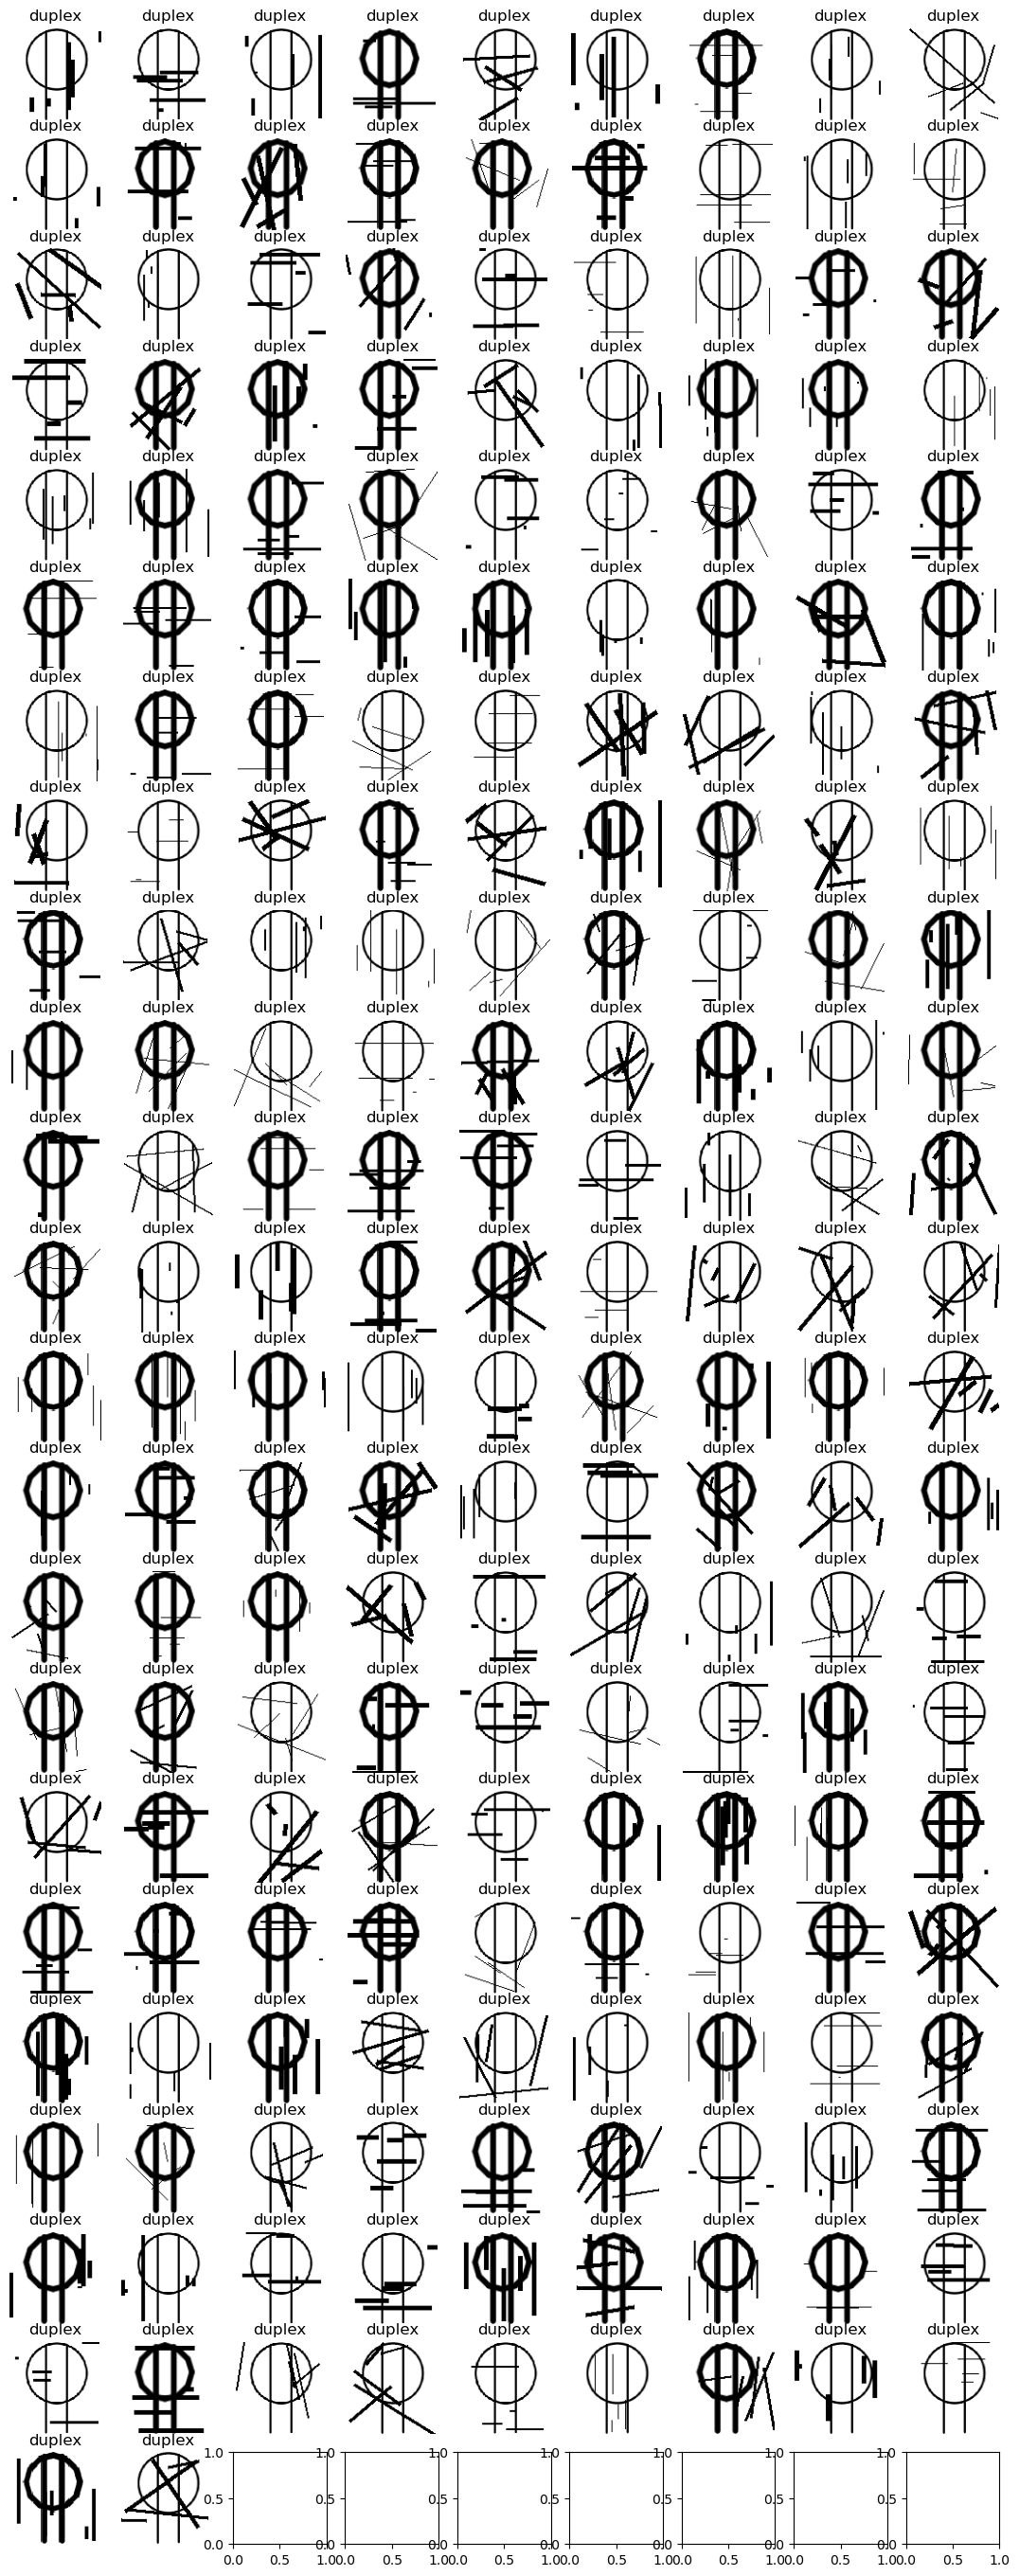

In [8]:
plot_image_arrays(df.imgarray,df.label)

# Embedding symbols in pictures

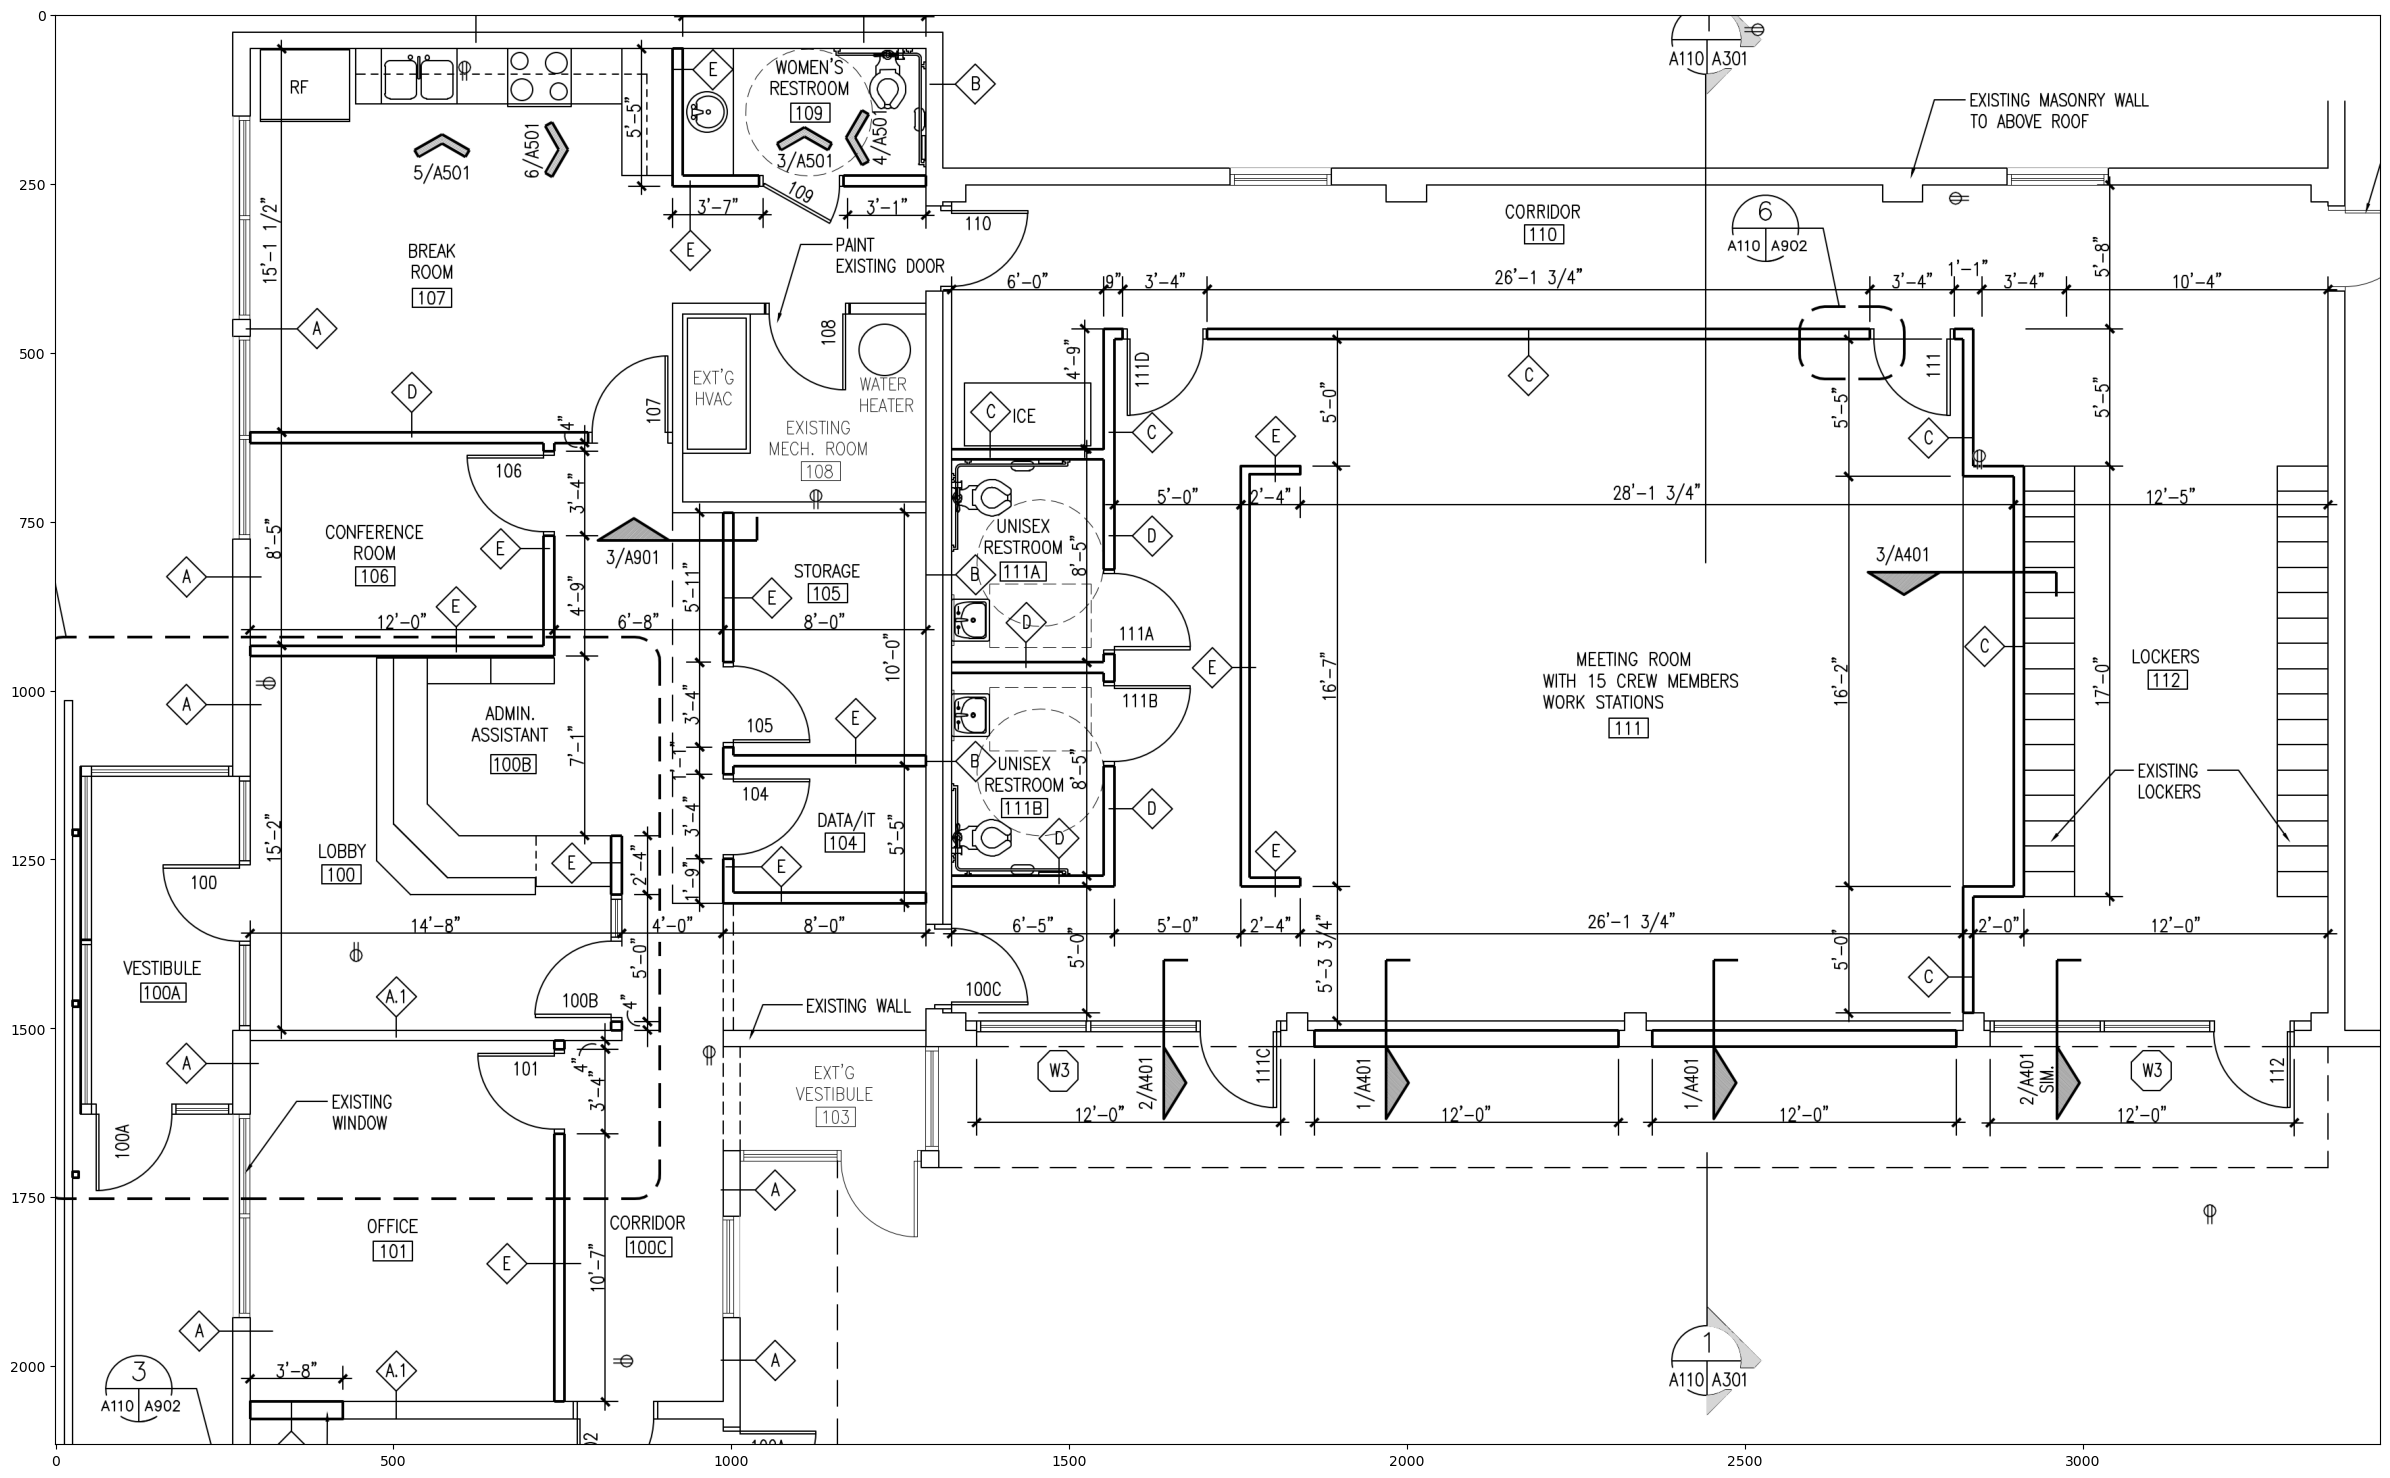

In [52]:
symbols_folder = '../data/img_format/input_ready/receptacle/'
drawings_folder = '../data/plans/3_cropped_plans/clean_wo_symbols/'
output_folder = '../data/auto_generated_training/'

# set up the number of images to overlay
num_images_to_overlay =10
overlay_scale = 0.3

# get a list of all the images from both symbols and drawings
input_images = os.listdir(symbols_folder)
background_images = os.listdir(drawings_folder)

# overlay_images = random.sample(input_images, num_images_to_overlay)
# background_image_name = random.choice(background_images)
# background_image = Image.open(os.path.join(drawings_folder, background_image_name)) # open the background image


overlay_images = random.sample(input_images, 1)*num_images_to_overlay
background_image_name = background_images[0]
background_image = Image.open(os.path.join(drawings_folder, background_image_name)) # open the background image


yolo_data = '' # add onto this string for each added symbol

for overlay_image in overlay_images:
    overlay = Image.open(os.path.join(symbols_folder, overlay_image)) # open this overlay image

    # plt.figure(figsize=(5,5))
    # plt.imshow(overlay)

    # convert (mostly) white pixels to transparent
    overlay = overlay.convert('RGBA')
    datas = overlay.getdata()
    newData = []
    for item in datas:
        if item[0] >= 255 and item[1] >= 255 and item[2] >= 255: # cutoff of 130. 255 would leave halos around the symbol
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
    overlay.putdata(newData)

    # plt.figure(figsize=(5,5))
    # plt.imshow(overlay)

    # resize the overlay to match the background drawing
    w, h = overlay.size
    overlay = overlay.resize((int(w*overlay_scale), int(h*overlay_scale)))

    angle = random.choice([0, 90, 180, 270]) # choose a random cardinal direction
    overlay = overlay.rotate(angle)

    # randomly position the overlay on the background
    x = random.randint(0, background_image.width - overlay.width)
    y = random.randint(0, background_image.height - overlay.height)
    background_image.paste(overlay, (x, y), overlay)
    # background_image.paste(overlay, (x, y))

    # add YOLO bounding box data to string
    x_center = (x + overlay.size[1]/2)
    y_center = (y + overlay.size[0]/2)
    width = overlay.size[1]
    height = overlay.size[0]
    yolo_data += f'0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n'


# output_path = os.path.join(output_folder, background_image_name)
# background_image.save(output_path)
# with open(os.path.join(output_path.replace('png','txt')), 'a') as f:
#     f.write(yolo_data)

plt.figure(figsize=(30,30))
plt.imshow(background_image)

# Make Duplex Symbol From Scratch

In [49]:
def plot_images(images_list):
    num_images = len(images_list)
    num_rows = math.ceil(math.sqrt(num_images))
    num_cols = math.ceil(num_images / num_rows)

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 10))
    axes = axes.flatten()

    for i, img in enumerate(images_list):
        axes[i].imshow(img)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

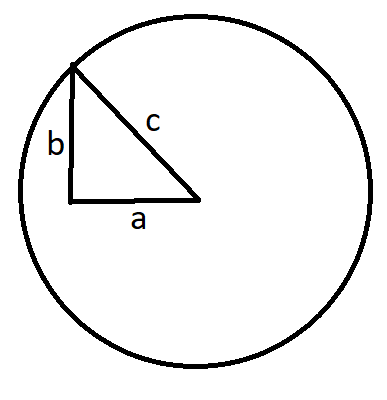

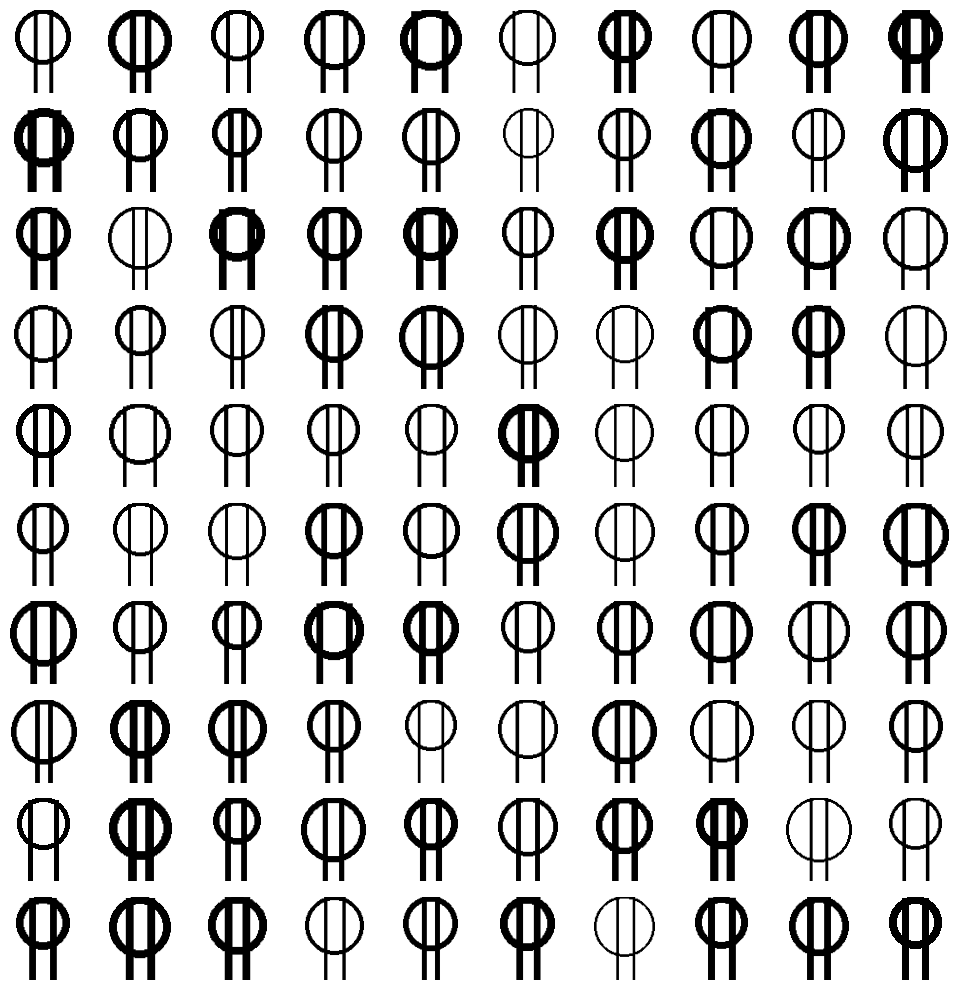

In [51]:
def draw_duplex_symbol():

    img = Image.new('RGB', (200, 200), color='white')

    draw = ImageDraw.Draw(img)

    line_thickness = random.randint(3, 8)
    circ_thickness = line_thickness + random.randint(0, 1)

    circ_corner = random.randint(20, 30)
    circ_radius = random.randint(25, 35)
    draw.ellipse((circ_corner, circ_corner, circ_corner + circ_radius*2, circ_corner + circ_radius*2), outline='black', width=circ_thickness)

    circ_middle = circ_corner + circ_radius

    tri_a = random.randint(7, 13) # distance from center of circle to each line
    tri_b = math.sqrt(circ_radius**2 - tri_a**2)

    # ~20% of images should have a random offset on one of the lines
    offset_left = 0
    offset_right = 0
    if random.randint(0,100) <= 20:
        offset = random.randint(1,4)
        if random.randint(0,1) == 0:
            offset_left = offset
        else:
            offset_right = offset

    line_length = random.randint(20, 40) # line length from bottom of circle

    draw.line((circ_middle-tri_a - offset_left,
               circ_middle-tri_b,
               circ_middle-tri_a - offset_left,
               circ_middle+tri_b+line_length
               ), fill='black', width=line_thickness)
    draw.line((circ_middle+tri_a + offset_right,
               circ_middle-tri_b,
               circ_middle+tri_a + offset_right,
               circ_middle+tri_b+line_length
               ),fill='black', width=line_thickness)

    # was having issues with getting crop to line up, so found a function online instead
    #img = img.crop((circ_1, circ_1, circ_1 + circ_radius*2 + 1, circ_middle+tri_b+line_length))

    def trim(im): # function I found online to trim whitespace
        bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
        diff = ImageChops.difference(im, bg)
        diff = ImageChops.add(diff, diff, 2.0, -100)
        bbox = diff.getbbox()
        if bbox:
            return im.crop(bbox)
        
    img = trim(img)

    # thought about using a blur, but changed my mind    
    #img = img.filter(ImageFilter.GaussianBlur(radius = 0.7))

    return img

# just display images for testing purposes
img_list = []
for x in range(100):
    img_list.append(draw_duplex_symbol())
plot_images(img_list)

In [897]:
#actaully create the images as files
for x in range(100):
    img = draw_duplex_symbol()
    img.save('../data/generated_symbols/duplex/' + str(x) + '.jpg')

# Make Telephony Symbol From Scratch

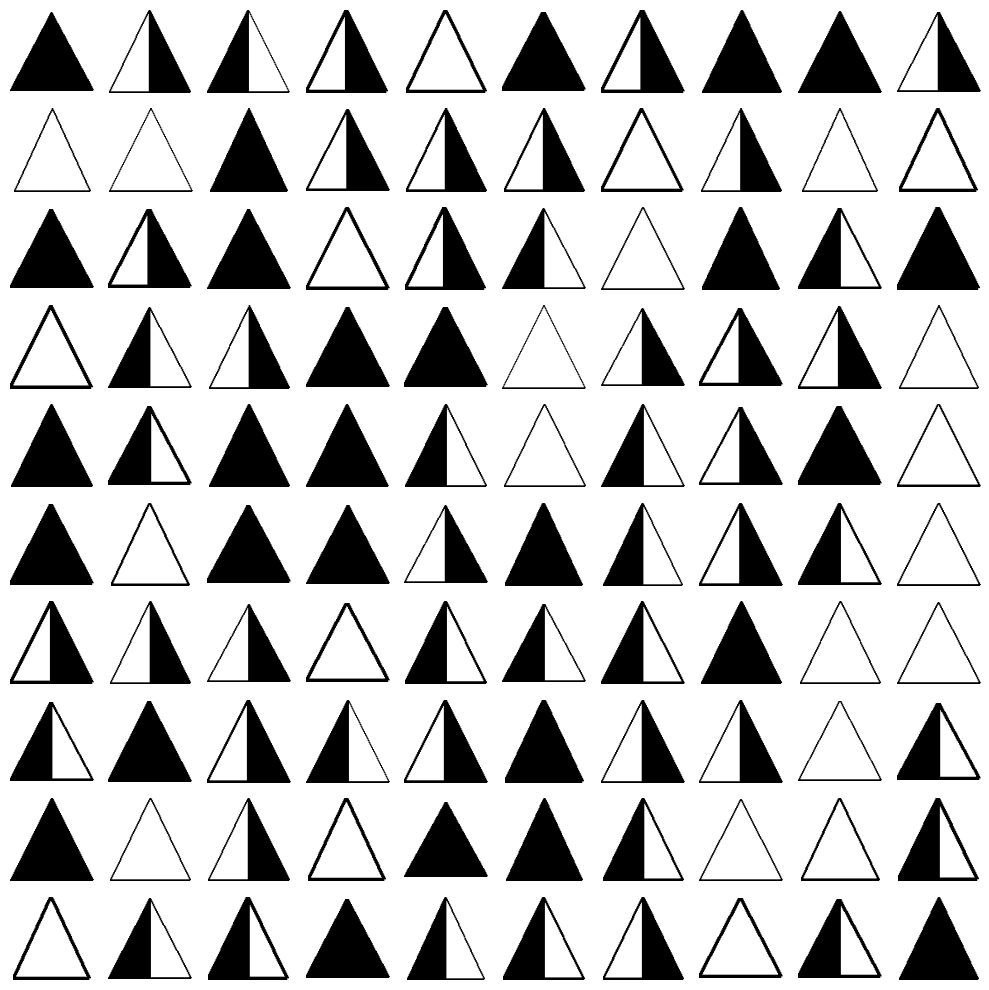

In [917]:
def draw_telephony_symbol():

    img = Image.new('RGB', (200, 200), color='white')

    draw = ImageDraw.Draw(img)

    line_thickness = random.randint(2, 4)

    width = random.randint(90,100)
    height = random.randint(90,100)

    tri_top = (width/2, 0)
    tri_left = (0, height)
    tri_right = (width, height)
    tri_center = (width/2, height)

    draw.line([tri_top, tri_left], fill='black', width=line_thickness)
    draw.line([tri_left, tri_right], fill='black', width=line_thickness)
    draw.line([tri_top, tri_right], fill='black', width=line_thickness)

    symbol_style = random.randint(0,3)
    if symbol_style == 0:
        draw.line([tri_top, tri_center], fill='black', width=line_thickness)
        flood_fill_seed = (width/2 + 10, height/2)
        ImageDraw.floodfill(img, flood_fill_seed, (0,0,0), thresh=50)
    elif symbol_style == 1:
        draw.line([tri_top, tri_center], fill='black', width=line_thickness)
        flood_fill_seed = (width/2 - 10, height/2)
        ImageDraw.floodfill(img, flood_fill_seed, (0,0,0), thresh=50)
    elif symbol_style == 2:
        flood_fill_seed = (width/2, height/2)
        ImageDraw.floodfill(img, flood_fill_seed, (0,0,0), thresh=50)
    elif symbol_style == 3:
        pass # empty triangle


    def trim(im): # function I found online to trim whitespace
        bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
        diff = ImageChops.difference(im, bg)
        diff = ImageChops.add(diff, diff, 2.0, -100)
        bbox = diff.getbbox()
        if bbox:
            return im.crop(bbox)
        
    img = trim(img)

    # thought about using a blur, but changed my mind    
    #img = img.filter(ImageFilter.GaussianBlur(radius = 0.7))

    return img

# just display images for testing purposes
img_list = []
for x in range(100):
    img_list.append(draw_telephony_symbol())
plot_images(img_list)

In [ ]:
#actaully create the images as files
for x in range(100):
    img = draw_telephony_symbol()
    img.save('../data/generated_symbols/telephony/' + str(x) + '.jpg')